# Regression and Prediction

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

In [56]:
lung = pd.read_csv('../../data/LungDisease.csv')

## Simple Linear regression:
$Y = b_0 + b_1 X$  

- A regression equation models the relationship between a predictor ($X$) and a response variable ($Y$). The model gives predicted values (fitted values) and prediction errors (residuals).
- The model is typically created using the _least squares method_, which minimizes the sum of the squares of the residuals in a regression model.
- Regression is used for both prediction and explanation of data.


[]

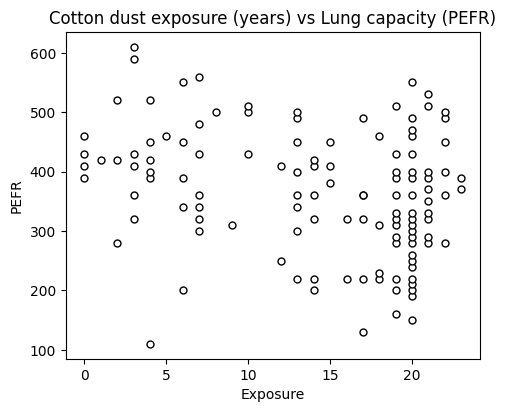

In [57]:
lung.plot.scatter(x='Exposure', y='PEFR', s=25, color='white', edgecolor='black', figsize=(5,4))
plt.tight_layout()
plt.title('Cotton dust exposure (years) vs Lung capacity (PEFR)')
plt.plot()

# in this case, PEFR = b0 + b1 Exposure

In [58]:
features = ['Exposure'] # x values, predictos (for matrix shaped)
target = 'PEFR' # y values, outcome

model = LinearRegression()
model.fit(lung[features], lung[target])

print(f'Intercept: {model.intercept_:.2f}')
print(f'Coefficient Exposure: {model.coef_[0]:.2f}')


Intercept: 424.58
Coefficient Exposure: -4.18


The intercept, or $b_0$, is 424.583 and can be interpreted as the predicted PEFR for a worker with zero years exposure. The regression coefficient, or $b_1$, can be interpreted as follows: for each additional year that a worker is exposed to cotton dust, the worker’s PEFR measurement is reduced by –4.185

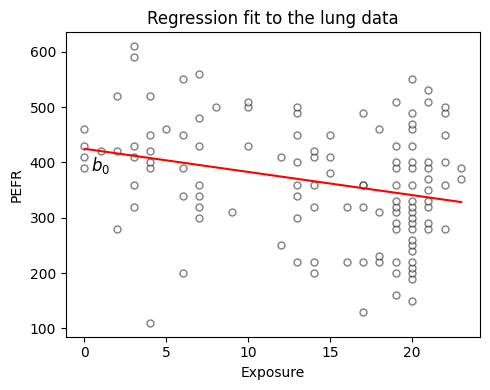

In [59]:
# Create a range of x values
x_range = [lung['Exposure'].min(), lung['Exposure'].max()]

# Calculate the corresponding y values for the line
y_range = model.intercept_ + model.coef_ * x_range

ax = lung.plot.scatter(x='Exposure', y='PEFR', s=25, color='white', edgecolor='black', figsize=(5,4), alpha=0.5)
ax.plot(x_range, y_range, color='r')
ax.text(0.4, model.intercept_-40, s=r'$b_0$', size='larger')
plt.title('Regression fit to the lung data')
plt.tight_layout()

In [60]:
# Fitted values, the prediction Y for each X
fitted = model.predict(lung[features])

# The error for each X (distance from Y value to predicted Y')
residuals = lung[target] - fitted

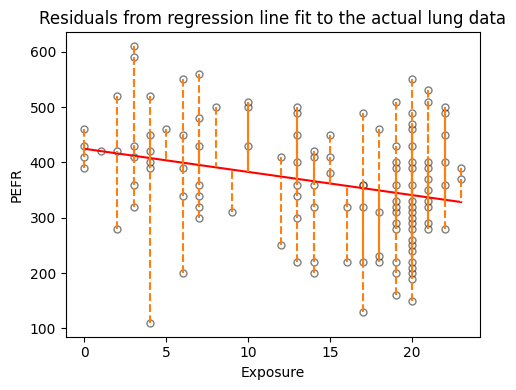

In [61]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', s=25, color='white', edgecolor='black', figsize=(5,4), alpha=0.5)
ax.plot(lung['Exposure'], fitted, color='r')

for x, y, y_fitted in zip(lung.Exposure, lung.PEFR, fitted):
    ax.plot((x,x), (y, y_fitted), '--', color='C1')

plt.title('Residuals from regression line fit to the actual lung data')
plt.tight_layout()

## Multiple Linear Regression

In [62]:
df = pd.read_csv('../../data/departamentos-en-venta-2020.csv')
apts_belgrano = df[df['Barrio'] == 'BELGRANO'][['Dolares', 'PropiedadS', 'Ambientes']]
apts_belgrano.columns = ['Price', 'm2', 'Rooms']

In [63]:
predictors = ['m2', 'Rooms'] # we could've had more variables, like bedrooms, restrooms, etc
target = 'Price'

apts_lm = LinearRegression()
apts_lm.fit(apts_belgrano[predictors], apts_belgrano[target])

LinearRegression()

In [64]:
print(f'Intercept:  {apts_lm.intercept_ : .3f}')

for var, coef in zip(predictors, apts_lm.coef_):
    print(f'Coef {var}: {coef : .3f}')

# predict price of apartments from Belgrano according to their surface (m2) and rooms

Intercept:  -8872.533
Coef m2:  4399.015
Coef Rooms: -23801.034


The interpretation of the coefficients in this multiple linear regression model is that the predicted Price changes by the coefficient value for each unit change in the corresponding predictor, assuming all other variables remain constant.  

- The coefficient for `m2` (4399.015) indicates that each additional square meter increases the estimated price by roughly 4399.015 dollars.
- The coefficient for `Rooms` (-23801.034) suggests that each additional room decreases the price by approximately 23801.034 dollars. These effects are independent of each other, holding all other variables constant. That is, holding the square meterage (m2) constant, each additional room is associated with a decrease in the apartment price.

Now, the same analysis but filtering out the outliers (since there are a few million dollars apartments).

In [65]:
# IQR for the Price column
Q1, Q3 = apts_belgrano['Price'].quantile(0.25), apts_belgrano['Price'].quantile(0.75)
IQR = Q3 - Q1

# Bounds for Price outliers (1.5 x IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_apts_belgrano = apts_belgrano[(apts_belgrano['Price'] >= lower_bound) &
                                       (apts_belgrano['Price'] <= upper_bound)]

apts_filt_lm = LinearRegression()
apts_filt_lm.fit(filtered_apts_belgrano[predictors], filtered_apts_belgrano[target])

print(f'Intercept:  {apts_filt_lm.intercept_ : .3f}')

for var, coef in zip(predictors, apts_filt_lm.coef_):
    print(f'Coef {var}: {coef : .3f}')

Intercept:   30191.181
Coef m2:  2060.522
Coef Rooms:  21378.799


Root Mean Squared Error (RMSE): It measures the average difference between actual and predicted prices. Lower RMSE indicates better model accuracy.

R-squared (r2) or Coefficient of Determination: It indicates how well the model explains the variance in actual prices, useful mainly in explanatory uses of regression where you want to assess how well the model fits the data. An R-squared closer to 1 means better explanatory power.

In [66]:
fitted = apts_filt_lm.predict(filtered_apts_belgrano[predictors])
RMSE = np.sqrt(mean_squared_error(filtered_apts_belgrano['Price'], fitted))
r2 = r2_score(filtered_apts_belgrano['Price'], fitted)

print(f'RMSE: {RMSE:.3f}')
print(f'r2: {r2:.3f}')

RMSE: 68954.929
r2: 0.725


In [67]:
model_explained = sm.OLS(filtered_apts_belgrano[target], filtered_apts_belgrano[predictors].assign(const=1))
results = model_explained.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                 1.354e+04
Date:                Sun, 09 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:53:56   Log-Likelihood:            -1.2927e+05
No. Observations:               10292   AIC:                         2.585e+05
Df Residuals:                   10289   BIC:                         2.586e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
m2          2060.5224     23.216     88.753      0.0

An **RMSE** of 68954.929 means your predictions are off (deviate) by about 68954.929 units on average.  

An **R^2** of 0.725 means your model explains 72.5% of the variation in apartment prices. Alternatively, we can say that `rooms` and `m2` explain 72.5% of the variation on `price`.   

The **null hypothesis in the context of a t-test in regression analysis** is typically that the coefficient for a certain predictor variable is equal to zero. This implies that the predictor has no effect on the outcome variable (example: H0 for m2, the coefficient for `m2` is 0, meaning `m2` has no effect on `Price`).  

The **p-value** in this model tells us the probability that you would see a t-statistic as extreme as the one you got if the null hypothesis were true (i.e., the coefficient is actually 0). A small p-value (typically ≤ 0.05) indicates strong evidence that the coefficient is different from 0. In your case, the p-values for `m2`, `Rooms`, and ‘const’ are all 0.000 (< 0.05), so we **reject the null hypothesis**, indicating that these **predictors are statistically significant**.